# Sentiment Analysis on Tweets
### By: Yassin Bedier, Ibrahim Labib, Alia Guda and Noor Abdelhady

##### 1. Import necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import nltk
from sklearn.svm import SVC
from xgboost import XGBClassifier
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

##### 2. Load the training dataset veg_train.csv in a dataframe df_train

In [2]:
df_train = pd.read_csv("data/train_data.csv")

##### 3. Display the first five rows in df_train

In [3]:
print(df_train.head())

   Tweet_ID                                              Tweet  Sentiment
0         1  RT @user Dear @user please cancel Sizzling Chi...          0
1         2          Honestly, fuck a cauliflower pizza crust.          0
2         3  @user I’m going all out this year lol. Bought ...          1
3         4  @user @user Yes and at the same time I’m a fra...          0
4         5        I need answers. A FUCKING SAP NO YAMS @user          0


##### 4. Plot the distribution count of the sentiment

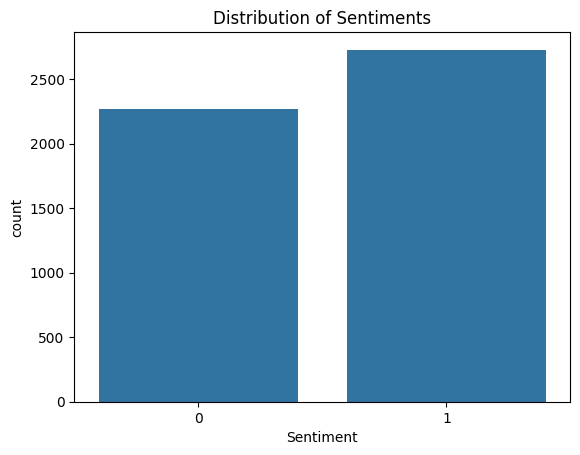

In [4]:
sns.countplot(x='Sentiment', data=df_train)
plt.title('Distribution of Sentiments')
plt.show()

##### 5. Perform Preprocessing on the tweets

In [7]:
# Only run the following downloads on your first time
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

# stop words
stop_words = set(stopwords.words('english'))
not_stopwords = {'not', 'bad', 'hate', 'isnt', 'no'}
stop_words = set([word for word in stop_words if word not in not_stopwords])

lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

# cleaning tweets
def text_preprocessing(text):
    processed_tweet = []
    # lowercase
    text = text.lower()

    # remove usernames
    text = re.sub(r'user', '', text)

    # remove retweet
    text = re.sub(r'rt', '', text)

    #handle emoticons
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', text)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', text)
    # Love -- <3, :*
    text = re.sub(r'(<3|:\*)', ' EMO_POS ', text)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    text = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', text)
    # Sad -- :-(, : (, :(, ):, )-:
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', text)
    # Cry -- :,(, :'(, :"(
    text = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', text)

    # remove special characters and punctuation.
    text = re.sub(r'[^\w\s:()]+', '', text)

    # remove all ascii
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # remove numbers
    text = re.sub(r'\d+', '', text)

    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # remove stop words
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

    words = text.split()

    for word in words:
        if (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None):
            word = str(porter_stemmer.stem(word))
            processed_tweet.append(word)

    return ' '.join(processed_tweet)

##### 6. Apply preprocessing to all tweets

In [8]:
df_train['Cleaned_Tweet'] = df_train['Tweet'].apply(text_preprocessing)

df_test = pd.read_csv("data/test_data.csv")
df_test['Cleaned_Tweet'] = df_test['Tweet'].apply(text_preprocessing)

new_tweets = ["Example tweet for preprocessing!", "rt @user tweet, dont eat food without punctuation and a ❤️ not 123 :) !!."]
cleaned_new_tweets = [text_preprocessing(tweet) for tweet in new_tweets]
print(cleaned_new_tweets)

['exampl tweet preprocess', 'tweet dont eat food without punctuat not emo_po']


In [9]:
df_test['Cleaned_Tweet'].head()

0    not squash cockroach continu thrive need prose...
1    mission suppo reversemigr bharat best amp divy...
2    avocado day keep gut microb happi studi show s...
3       life expens emo_neg pumpkin not even good time
4                                   infinit beauti omg
Name: Cleaned_Tweet, dtype: object

##### 7. Splitting data to training (80%) and validation dataset  (20%)

In [10]:
X = df_train['Cleaned_Tweet']
y = df_train['Sentiment']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

##### 8. Vectorizing preprocessed tweets (Training and Validation ) using Binary Bag of words BBoW

In [11]:
vectorizer_bbow = CountVectorizer(binary=True)
X_train_bbow = vectorizer_bbow.fit_transform(X_train)
X_val_bbow = vectorizer_bbow.transform(X_val)

##### 9. Vectorizing preprocessed tweets (Training and Validation ) using TF-IDF

In [12]:
vectorizer_tfidf = TfidfVectorizer()
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_val_tfidf = vectorizer_tfidf.transform(X_val)

##### 10. Use the Following ML Models
- Logistic Regression
- Decision Trees
- KNN
- Random Forest
- XG Boost
- SVC

In [13]:
# Logistic Regression
model_lr = LogisticRegression(
    penalty='l2',
    C=80,
    solver='saga',
    max_iter=1000,
    class_weight='balanced'
)
model_lr.fit(X_train_bbow, y_train)
pred_lr_bbow_train = model_lr.predict(X_train_bbow)
pred_lr_bbow_val = model_lr.predict(X_val_bbow)
accuracy_lr_bbow_train = accuracy_score(y_train, pred_lr_bbow_train)
accuracy_lr_bbow_val = accuracy_score(y_val, pred_lr_bbow_val)

model_lr.fit(X_train_tfidf, y_train)
pred_lr_tfidf_train = model_lr.predict(X_train_tfidf)
pred_lr_tfidf_val = model_lr.predict(X_val_tfidf)
accuracy_lr_tfidf_train = accuracy_score(y_train, pred_lr_tfidf_train)
accuracy_lr_tfidf_val = accuracy_score(y_val, pred_lr_tfidf_val)

In [14]:
# Decision Trees
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_bbow, y_train)
pred_dt_bbow_train = model_dt.predict(X_train_bbow)
pred_dt_bbow_val = model_dt.predict(X_val_bbow)
accuracy_dt_bbow_train = accuracy_score(y_train, pred_dt_bbow_train)
accuracy_dt_bbow_val = accuracy_score(y_val, pred_dt_bbow_val)

model_dt.fit(X_train_tfidf, y_train)
pred_dt_tfidf_train = model_dt.predict(X_train_tfidf)
pred_dt_tfidf_val = model_dt.predict(X_val_tfidf)
accuracy_dt_tfidf_train = accuracy_score(y_train, pred_dt_tfidf_train)
accuracy_dt_tfidf_val = accuracy_score(y_val, pred_dt_tfidf_val)

In [15]:
# K-Nearest Neighbors (KNN)
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_bbow, y_train)
pred_knn_bbow_train = model_knn.predict(X_train_bbow)
pred_knn_bbow_val = model_knn.predict(X_val_bbow)
accuracy_knn_bbow_train = accuracy_score(y_train, pred_knn_bbow_train)
accuracy_knn_bbow_val = accuracy_score(y_val, pred_knn_bbow_val)

model_knn.fit(X_train_tfidf, y_train)
pred_knn_tfidf_train = model_knn.predict(X_train_tfidf)
pred_knn_tfidf_val = model_knn.predict(X_val_tfidf)
accuracy_knn_tfidf_train = accuracy_score(y_train, pred_knn_tfidf_train)
accuracy_knn_tfidf_val = accuracy_score(y_val, pred_knn_tfidf_val)

In [16]:
# random forest
model_rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=2,
    random_state=42,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features="log2",
    class_weight='balanced'
)

model_rf.fit(X_train_bbow, y_train)
pred_rf_bbow_train = model_rf.predict(X_train_bbow)
pred_rf_bbow_val = model_rf.predict(X_val_bbow)
accuracy_rf_bbow_train = accuracy_score(y_train, pred_rf_bbow_train)
accuracy_rf_bbow_val = accuracy_score(y_val, pred_rf_bbow_val)

model_rf.fit(X_train_tfidf, y_train)
pred_rf_tfidf_train = model_rf.predict(X_train_tfidf)
pred_rf_tfidf_val = model_rf.predict(X_val_tfidf)
accuracy_rf_tfidf_train = accuracy_score(y_train, pred_rf_tfidf_train)
accuracy_rf_tfidf_val = accuracy_score(y_val, pred_rf_tfidf_val)

In [17]:
# xg boost
model_xg = XGBClassifier(max_depth=25, n_estimators=400)
model_xg.fit(X_train_bbow, y_train)
pred_xg_bbow_train = model_xg.predict(X_train_bbow)
pred_xg_bbow_val = model_xg.predict(X_val_bbow)
accuracy_xg_bbow_train = accuracy_score(y_train, pred_xg_bbow_train)
accuracy_xg_bbow_val = accuracy_score(y_val, pred_xg_bbow_val)

model_xg.fit(X_train_tfidf, y_train)
pred_xg_tfidf_train = model_xg.predict(X_train_tfidf)
pred_xg_tfidf_val = model_xg.predict(X_val_tfidf)
accuracy_xg_tfidf_train = accuracy_score(y_train, pred_xg_tfidf_train)
accuracy_xg_tfidf_val = accuracy_score(y_val, pred_xg_tfidf_val)

In [18]:
# svc
model_svc = SVC(kernel='linear', gamma='auto', class_weight='balanced', probability=True)
model_svc.fit(X_train_bbow, y_train)
pred_svc_bbow_train = model_svc.predict(X_train_bbow)
pred_svc_bbow_val = model_svc.predict(X_val_bbow)
accuracy_svc_bbow_train = accuracy_score(y_train, pred_svc_bbow_train)
accuracy_svc_bbow_val = accuracy_score(y_val, pred_svc_bbow_val)

model_svc.fit(X_train_tfidf, y_train)
pred_svc_tfidf_train = model_svc.predict(X_train_tfidf)
pred_svc_tfidf_val = model_svc.predict(X_val_tfidf)
accuracy_svc_tfidf_train = accuracy_score(y_train, pred_svc_tfidf_train)
accuracy_svc_tfidf_val = accuracy_score(y_val, pred_svc_tfidf_val)

##### 11.  Construct the Results dataframe with the accuracy for each model

In [19]:
df_result = pd.DataFrame({
    'Classifier': ['Logistic Regression', 'KNN', 'Decision Trees', 'Random Forest', 'XG Boost', 'SVC'],
    'BBOW_Train': [accuracy_lr_bbow_train, accuracy_knn_bbow_train, accuracy_dt_bbow_train, accuracy_rf_bbow_train, accuracy_xg_bbow_train, accuracy_svc_bbow_train],
    'BBOW_Val': [accuracy_lr_bbow_val, accuracy_knn_bbow_val, accuracy_dt_bbow_val, accuracy_rf_bbow_val, accuracy_xg_bbow_val, accuracy_svc_bbow_val],
    'TF-IDF_Train': [accuracy_lr_tfidf_train, accuracy_knn_tfidf_train, accuracy_dt_tfidf_train, accuracy_rf_tfidf_train, accuracy_xg_tfidf_train, accuracy_svc_tfidf_train],
    'TF-IDF_Val': [accuracy_lr_tfidf_val, accuracy_knn_tfidf_val, accuracy_dt_tfidf_val, accuracy_rf_tfidf_val, accuracy_xg_tfidf_val, accuracy_svc_tfidf_val]
})

print(df_result)

            Classifier  BBOW_Train  BBOW_Val  TF-IDF_Train  TF-IDF_Val
0  Logistic Regression     0.99975     0.929       0.99950       0.932
1                  KNN     0.78825     0.733       0.56200       0.582
2       Decision Trees     0.99975     0.855       0.99975       0.845
3        Random Forest     0.99975     0.913       0.99975       0.906
4             XG Boost     0.99225     0.898       0.99700       0.893
5                  SVC     0.99675     0.924       0.98700       0.934


##### 12. Save the Results dataframe in "models_accuracy.csv" file

In [20]:
df_result.to_csv("data/models_accuracy.csv", index=False)

##### 13. Select the best model in the table with the highest accuract, then use this model to predict a new tweet

In [21]:
best_bbow_val = df_result['BBOW_Val'].max()
best_tfidf_val = df_result['TF-IDF_Val'].max()

if best_bbow_val > best_tfidf_val:
    best_model = df_result.loc[df_result['BBOW_Val'].idxmax()]
    best_vectorization = 'BBOW'
else:
    best_model = df_result.loc[df_result['TF-IDF_Val'].idxmax()]
    best_vectorization = 'TF-IDF'

print(f"The best model is: {best_model['Classifier']} with {best_vectorization} having validation accuracy {max(best_bbow_val, best_tfidf_val):.2f}")


# choose best model
if best_model['Classifier'] == 'Logistic Regression':
    model_best = model_lr
elif best_model['Classifier'] == 'KNN':
    model_best = model_knn
elif best_model['Classifier'] == 'Decision Trees':
    model_best = model_dt
elif best_model['Classifier'] == 'Random Forest':
    model_best = model_rf
elif best_model['Classifier'] == 'XG Boost':
    model_best = model_xg
elif best_model['Classifier'] == 'SVC':
    model_best = model_svc

if best_vectorization == 'BBOW':
    model_best.fit(X_train_bbow, y_train)
else:
    model_best.fit(X_train_tfidf, y_train)

#predict new tweet
new_tweet = ["Cucumber tastes so bad bro i hate it man"]

# Vectorize the new tweet
if best_vectorization == 'BBOW':
    new_tweet_vectorized = vectorizer_bbow.transform(new_tweet)
else:
    new_tweet_vectorized = vectorizer_tfidf.transform(new_tweet)

new_tweet_prediction = model_best.predict(new_tweet_vectorized)
print(f"The predicted label for the new tweet is: {new_tweet_prediction[0]}")

The best model is: SVC with TF-IDF having validation accuracy 0.93
The predicted label for the new tweet is: 0


## Now, we will use a Natural Language Processing Model with PyTorch to see how well it work

##### 1. Load the training and testing data

In [22]:
df_test = pd.read_csv("data/test_data.csv")
df_train = pd.read_csv("data/train_data.csv")

##### 2. Split the training data into 80% training and 20% validation

In [23]:
# Here we do not clean/preproccess the tweets as our model works best on raw tweets without any preproccessing
X = df_train['Tweet']
y = df_train['Sentiment']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

##### 3. Create and train the PyTorch model

In [24]:
# Set the device used as GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained tokenizer and model called 'roberta-base'.
# We chose roberta-base over bert as it is more trained on tweets and has higher accuracy
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
# Move the model to the specified device (GPU cuda)
model.to(device)

# Tokenize and encode input sequences
def encode_sequences(texts, max_length=128):
    return tokenizer.batch_encode_plus(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )

# Encode the training and validation data
X_train_encoded = encode_sequences(X_train.tolist())
X_val_encoded = encode_sequences(X_val.tolist())

# Convert labels to PyTorch tensors
y_train = torch.tensor(y_train.tolist())
y_val = torch.tensor(y_val.tolist())

# Create TensorDatasets for training and validation data
train_dataset = TensorDataset(X_train_encoded['input_ids'], X_train_encoded['attention_mask'], y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

# Create DataLoaders for faster batching and parallelization
val_dataset = TensorDataset(X_val_encoded['input_ids'], X_val_encoded['attention_mask'], y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Training function
def train(model, train_loader, val_loader, epochs):
    # Calculate total training steps for the learning rate scheduler
    total_steps = len(train_loader) * epochs

    # Initialize the optimizer and learning rate scheduler (which increases/decreases based on accuracy after each epoch)
    optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        train_loss = 0

        # Training loop
        # We are using the library called tqdm to show us progress of each epoch so we know how long we have to wait for
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            # Move the batch to device and unpack
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass
            loss.backward()

            # Clip gradients to prevent exploding gradients and shorter time
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update weights
            optimizer.step()

            # Update the learning rate
            scheduler.step()

            train_loss += loss.item()

        # Validation loop
        model.eval() # Set model to evaluation mode
        val_loss = 0
        predictions, true_labels = [], []

        with torch.no_grad(): # Here we disabled gradient calculation for validation so it can run faster
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids, attention_mask, labels = [b.to(device) for b in batch]

                # Forward pass
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

                # Get predictions
                logits = outputs.logits
                predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        # Here we calculate the average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        # Calculate accuracy
        accuracy = accuracy_score(true_labels, predictions)

        # Print this epoch's results
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy: {accuracy:.4f}")
        print(classification_report(true_labels, predictions))

# Train the model
train(model, train_loader, val_loader, epochs=3)

# Function we defined to get predictions to ensure that no gradients are calculated during prediction to speed up inference
@torch.no_grad()
def get_predictions(model, dataloader):
    model.eval() # set model to evaluation mode
    predictions = []
    for batch in tqdm(dataloader, desc="Predicting"):
        input_ids, attention_mask, _ = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
    return predictions

# Get predictions for validation set
val_predictions = get_predictions(model, val_loader)

# Print final validation accuracy and classification report
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Final Validation Accuracy: {val_accuracy:.4f}")
print(classification_report(y_val, val_predictions))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future 

Epoch 1/3
Train Loss: 0.2635
Val Loss: 0.0997
Val Accuracy: 0.9720
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       439
           1       1.00      0.95      0.97       561

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



Epoch 2/3:   0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Validation: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 2/3
Train Loss: 0.0617
Val Loss: 0.0375
Val Accuracy: 0.9870
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       439
           1       1.00      0.98      0.99       561

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



Epoch 3/3:   0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Validation: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 3/3
Train Loss: 0.0251
Val Loss: 0.0497
Val Accuracy: 0.9870
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       439
           1       0.99      0.99      0.99       561

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



Predicting:   0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Predicting: 100%|██████████| 16/16 [00:06<00:00,  2.31it/s]

Final Validation Accuracy: 0.9870
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       439
           1       0.99      0.99      0.99       561

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



##### 4. Now, we will run the model on our testing data and find out the sentiment for each tweet

In [25]:
#  Prepare the test data (we use raw tweets without preprocessing as the accuracy rate is higher on this model)
test_encoded = encode_sequences(df_test['Tweet'].tolist())
test_dataset = TensorDataset(test_encoded['input_ids'], test_encoded['attention_mask'], torch.zeros(len(df_test)))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Get predictions for test data
test_predictions = get_predictions(model, test_loader)

# Create final dataframe
submission = pd.DataFrame({
    'Tweet_ID': df_test['Tweet_ID'],
    'Sentiment': test_predictions
})

# save final predictions to csv file
submission.to_csv('data/submission_roberta.csv', index=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Predicting: 100%|██████████| 16/16 [00:06<00:00,  2.30it/s]


## Now we are done. The sentiments are saved in the `submission_roberta.csv` file.
## This was a Kaggle Competition, and we have ended up in 1st place with a 99% accuracy.